In [2]:
#Pandas and numpy
import pandas as pd
import numpy as np
import datetime

#Automated EDA visualisation
import sweetviz as sv

#All my sklearn models/packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split

import sklearn.metrics as metrics

#Ploting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Plotting geodata
import geopandas
from shapely import wkt
import contextily as ctx
import xyzservices.providers as xyz

In [3]:
crash_df = pd.read_csv("crashes.csv")

In [4]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577144 entries, 0 to 577143
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                577144 non-null  object 
 1   RD_NO                          573882 non-null  object 
 2   CRASH_DATE_EST_I               43618 non-null   object 
 3   CRASH_DATE                     577144 non-null  object 
 4   POSTED_SPEED_LIMIT             577144 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         577144 non-null  object 
 6   DEVICE_CONDITION               577144 non-null  object 
 7   WEATHER_CONDITION              577144 non-null  object 
 8   LIGHTING_CONDITION             577144 non-null  object 
 9   FIRST_CRASH_TYPE               577144 non-null  object 
 10  TRAFFICWAY_TYPE                577144 non-null  object 
 11  LANE_CNT                       198978 non-null  float64
 12  ALIGNMENT                     

In [5]:
crash_df.BEAT_OF_OCCURRENCE.unique()

array([2515.,  834.,  331.,  224., 1654., 1732., 1115., 1822.,  225.,
       1034., 1113.,  131.,  334.,  511., 2511.,  212.,  234.,  623.,
       1011., 1655.,  222., 1412., 2411., 1821.,  412., 1135.,  814.,
        524., 1922., 1414., 1235., 1925., 1513., 1221.,  411., 2223.,
       1111.,  523., 1911., 1832.,  124., 1611.,  733., 1224., 1032.,
        413., 1214., 1431.,  423., 1634., 2521., 1934., 1621.,  114.,
        233., 1653., 2211., 1523.,  324., 1921., 1724.,  824., 2534.,
       1733., 1215., 1834.,  911.,  822.,  611., 1713., 1622.,  211.,
       2423.,  823.,  833., 1813., 1532.,  724., 1935., 1031.,  933.,
       2531., 1233., 1234.,  711.,  532., 1023., 2031., 2212.,  923.,
       1012., 1824.,  633., 1133., 1432., 2432.,  111.,  323., 2413.,
       1711., 1912., 1422., 1652., 2533., 1712.,  533.,  122., 2032.,
        121., 1433., 1651., 1932., 1212.,  725.,  831., 1022., 1913.,
       2222.,  714., 1222.,  811.,  432., 1424.,   nan,  313., 1624.,
        422., 2022.,

In [6]:
crash_df.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

Let's go through these columns and see what is usable as a feature

- CRASH_RECORD_ID is not meaningful
- CRASH_DATE_EST_I is mostly N/A, we can use CRASH_DATE instead (which has no null values)
- CRASH_DATE, we'll instead use HOUR, DAY_OF_WEEK and MONTH
- POSTED_SPEED_LIMIT can be used
- LANE_CNT could be used but many NA values
- BEAT_OF_OCCURANCE could be used. Should be treated as int or categorical? Is the number meaningful? Update: first 1 or 2 digits give district. So it should be useful as a numeric feature. Could split up into a district feature.
- TRAFFIC_CONTROL_DEVICE, DEVICE_CONDITION, WEATHER_CONDITION, LIGHTING_CONDITION, TRAFFICWAY_TYPE, ROADWAY_SURFACE_CONDITION, ROAD_DEFECT needs to be dummified, could be used
- FIRST_CRASH_TYPE, ALIGNMENT, REPORT_TYPE, CRASH_TYPE, NOT_RIGHT_OF_WAY_I, DAMAGE, DATE_POLICE_NOTIFIED, PRIM_CONTRIBUTORY_CAUSE, SEC_CONTRIBUTORY_CAUSE, PHOTOS_TAKE_I, STATEMENTS_TAKEN_I, NUM_UNITS,'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL','INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION','INJURIES_UNKNOWN', 'DOORING_I' are all post-crash info. We won't include as features, but some may be interesting to examine in more detail to motivate the question or restrict our analysis (i.e. perhaps we should only look at 'serious' hit and runs where someone is injured or a lot of damage is done)
- WORK_ZONE_I could be useful, need to be dummified
- WORK_ZONE_TYPE and WORKERS_PRESENT_I only apply to crashes in work zones, probably won't include those.
- HIT_AND_RUN_I is our target
- LATITUDE, LONGITUDE are useful
- LOCATION has the same info as LONG & LAT, won't be used as a feature but useful for geodata packages
- STREET_NAME, STREET_NO, STREET_DIRECTION could be used, but overlap with LOCATION. We'll start by not including them.

In [7]:
crash_df["HAR"] = crash_df.HIT_AND_RUN_I.apply(lambda x: 1 if x=="Y" else 0)

In [8]:
crash_df.HAR.unique()

array([0, 1])

In [9]:
crash_df.CRASH_DATE = pd.to_datetime(crash_df.CRASH_DATE)

In [10]:
crash_df.CRASH_DATE.head()

0   2019-07-10 17:56:00
1   2017-06-30 16:00:00
2   2020-07-10 10:25:00
3   2020-07-11 01:00:00
4   2020-07-08 14:00:00
Name: CRASH_DATE, dtype: datetime64[ns]

In [11]:
#report = sv.analyze(crash_df, target_feat = "HAR")
#report.show_html()

Some take aways from this initial EDA

* Hit & runs are more likely to happen at night
* Hit & runs account for a large percentage of crashes involving pedestrians and fatal crashes
* Lighting, weather, road condition are relevant
* All 'unknown' values are very correlated with hit and runs. This makes sense, but we can't use that. Have to get rid of UNKNOWN values somehow
* Fewer hit and runs in January. Why?
* Many hit & runs involve parked cars
* Many hit & runs have small amounts of damage
* Hit & runs are more likely on one way streets and alleys
* Hit and runs account for 29% of crashes
* Hit and runs are more likely at stop signs
* Most crashes occur in 30-35 speed limit zones, but hit and runs occur at slower and faster speed limit zones
* Device condition does not seem correlated with hit and runs
* Crashes are more likely when the weather is anything but clear
* No major difference between dark and dark with lighted road


In [12]:
crash_df.columns
crash_df.HAR.sum()

167901

Let's create a decision tree model based on just a few features as an MVP

In [13]:
features = ["POSTED_SPEED_LIMIT",
            "BEAT_OF_OCCURRENCE","CRASH_HOUR","CRASH_DAY_OF_WEEK",
            "CRASH_MONTH","LATITUDE","LONGITUDE"]


In [14]:
crash_df2 = crash_df[features+["HAR"]].dropna()
crash_df2.HAR.sum()

167226

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(crash_df2, target = 'HAR', 
                                                                train_size=0.6, valid_size=0.2, test_size=0.2)

First we'll train a simple Decision tree on a few features

In [16]:
class_tree = DecisionTreeClassifier(ccp_alpha=.01)
class_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01)

In [17]:
class_tree.score(X_val,y_val)

0.7098511520897968

In [18]:
class_tree.feature_importances_

array([0., 0., 0., 0., 0., 0., 0.])

The most important features are

- The location
- The month
- And the hour

Here we create some figures

In [19]:
hour_info = crash_df[["HAR","CRASH_HOUR","CRASH_RECORD_ID"]].groupby(["HAR", "CRASH_HOUR"]).count()

In [20]:
all_hour_counts = crash_df.CRASH_HOUR.value_counts()
har_hour_counts = crash_df[crash_df.HAR== 1].CRASH_HOUR.value_counts()

In [21]:
all_hour_per = all_hour_counts/crash_df.shape[0]
har_hour_per = har_hour_counts/crash_df[crash_df.HAR== 1].shape[0]

In [22]:
all_hour_per.sort_index(inplace = True)

In [23]:
har_hour_per.sort_index(inplace = True)

In [24]:
x = har_hour_per.index
y1 = all_hour_per
y2 = har_hour_per

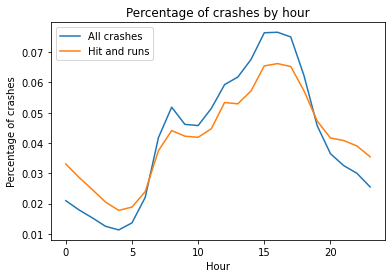

In [26]:
plt.title("Percentage of crashes by hour")
plt.xlabel("Hour")
plt.ylabel("Percentage of crashes")

plt.plot(x, y1, label="All crashes")
plt.plot(x, y2, label="Hit and runs")
plt.legend()

plt.savefig("crash_by_hour.png", dpi=900,bbox_inches="tight")

Let's clean-up and dummify our features. Making sure we don't include any N/A or unknown values.

Starting with Lighting condition

In [27]:
crash_df.LIGHTING_CONDITION.value_counts()

DAYLIGHT                  373203
DARKNESS, LIGHTED ROAD    126323
DARKNESS                   28434
UNKNOWN                    21963
DUSK                       17342
DAWN                        9879
Name: LIGHTING_CONDITION, dtype: int64

Create a feature called DARK that is 1 if it is DARKNESS (with or without road lighing)

In [28]:
crash_df["DARK"] = crash_df.LIGHTING_CONDITION.apply(lambda x: 1 if "DARKNESS" in x else 0)

In [29]:
crash_df.DARK.value_counts()

0    422387
1    154757
Name: DARK, dtype: int64

Next up - Weather condition

In [30]:
crash_df.WEATHER_CONDITION.value_counts()

CLEAR                       458138
RAIN                         50379
UNKNOWN                      26149
SNOW                         20846
CLOUDY/OVERCAST              17137
OTHER                         1766
FOG/SMOKE/HAZE                 882
FREEZING RAIN/DRIZZLE          787
SLEET/HAIL                     752
BLOWING SNOW                   186
SEVERE CROSS WIND GATE         120
BLOWING SAND, SOIL, DIRT         2
Name: WEATHER_CONDITION, dtype: int64

In [31]:
crash_df["VIS_WEATHER"] = crash_df.WEATHER_CONDITION.apply(lambda x: 0 if 
                                                           x == "CLEAR" or x == "UNKNOWN" 
                                                           or x == "OTHER" or x == "CLOUDY/OVERCAST"
                                                          else 1)

In [32]:
crash_df.VIS_WEATHER.value_counts()

0    503190
1     73954
Name: VIS_WEATHER, dtype: int64

In [33]:
crash_df["OVERCAST"] = crash_df.WEATHER_CONDITION.apply(lambda x: 1 if 
                                                           x == "CLOUDY/OVERCAST"
                                                          else 0)

In [34]:
crash_df.OVERCAST.value_counts()

0    560007
1     17137
Name: OVERCAST, dtype: int64

For traffic control, just group no control and everything else

In [35]:
crash_df.TRAFFIC_CONTROL_DEVICE.value_counts()

NO CONTROLS                 332071
TRAFFIC SIGNAL              160234
STOP SIGN/FLASHER            57437
UNKNOWN                      19012
OTHER                         3545
LANE USE MARKING              1226
YIELD                          814
OTHER REG. SIGN                595
OTHER WARNING SIGN             521
RAILROAD CROSSING GATE         381
PEDESTRIAN CROSSING SIGN       283
POLICE/FLAGMAN                 207
DELINEATORS                    194
SCHOOL ZONE                    191
FLASHING CONTROL SIGNAL        185
OTHER RAILROAD CROSSING        138
RR CROSSING SIGN                67
NO PASSING                      26
BICYCLE CROSSING SIGN           17
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64

In [36]:
crash_df["NO_TRAFFIC_CONTROL"] = crash_df.TRAFFIC_CONTROL_DEVICE.apply(lambda x: 1 
                                                                       if x == "NO CONTROLS" or x == "UNKNOWN"
                                                                       else 0)

In [37]:
crash_df.NO_TRAFFIC_CONTROL.value_counts()

1    351083
0    226061
Name: NO_TRAFFIC_CONTROL, dtype: int64

In [38]:
crash_df.WORK_ZONE_I.value_counts()

Y    2827
N     754
Name: WORK_ZONE_I, dtype: int64

For work zone, map all nulls to N

In [39]:
crash_df["WORK_ZONE"] = crash_df.WORK_ZONE_I.apply(lambda x: 1 if x == "Y" else 0)

In [40]:
crash_df.WORK_ZONE.value_counts()

0    574317
1      2827
Name: WORK_ZONE, dtype: int64

In [41]:
crash_df.TRAFFICWAY_TYPE.value_counts()

NOT DIVIDED                        255381
DIVIDED - W/MEDIAN (NOT RAISED)     98774
ONE-WAY                             75983
PARKING LOT                         40289
DIVIDED - W/MEDIAN BARRIER          34055
FOUR WAY                            23872
OTHER                               16091
ALLEY                                9466
UNKNOWN                              6376
T-INTERSECTION                       5081
CENTER TURN LANE                     4623
DRIVEWAY                             1969
RAMP                                 1819
UNKNOWN INTERSECTION TYPE            1314
Y-INTERSECTION                        583
FIVE POINT, OR MORE                   582
TRAFFIC ROUTE                         443
NOT REPORTED                          220
ROUNDABOUT                            141
L-INTERSECTION                         82
Name: TRAFFICWAY_TYPE, dtype: int64

There's a lot of information here, but it's hard to parse out. Let's leave it for now

In [42]:
#crash_df["UNDIVIDED"] = crash_df.apply(lambda x: 1 if x in ["NOT DIVIDED", "OTHER", 
#                                                            "UNKNOWN", "UNKNOWN INTERSECTION TYPE",
#                                                           "NOT REPORTED"])

In [43]:
crash_df.ROADWAY_SURFACE_COND.value_counts()

DRY                433606
WET                 76904
UNKNOWN             39902
SNOW OR SLUSH       20914
ICE                  4177
OTHER                1397
SAND, MUD, DIRT       244
Name: ROADWAY_SURFACE_COND, dtype: int64

In [44]:
crash_df["DRY"] = crash_df.ROADWAY_SURFACE_COND.apply(lambda x: 1 if x in ["DRY", "UNKNOWN","OTHER"] else 0)

In [45]:
crash_df.DRY.value_counts()

1    474905
0    102239
Name: DRY, dtype: int64

We've picked out some features. Let's train some models.

In [46]:
features = ["POSTED_SPEED_LIMIT",
            "BEAT_OF_OCCURRENCE","CRASH_HOUR","CRASH_DAY_OF_WEEK",
            "CRASH_MONTH","LATITUDE","LONGITUDE", "DARK", "VIS_WEATHER","OVERCAST","NO_TRAFFIC_CONTROL",
           "WORK_ZONE","DRY"]

crash_df3 = crash_df[features+["HAR"]].dropna()

X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(crash_df3, target = 'HAR', 
                                                                train_size=0.6, valid_size=0.2, test_size=0.2)

In [47]:
model_dict = {}

In [48]:
#Train Random forest
rand_forest = RandomForestClassifier(class_weight="balanced")
rand_forest.fit(X_train, y_train)

model_dict["Random Forest"] = rand_forest



In [50]:
y_pred = rand_forest.predict(X_val)
metrics.f1_score(y_val,y_pred)

0.24286061355655186

In [51]:
#Train Logistic regression
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train, y_train)

model_dict["Logistic Regression"] = log_reg

y_pred = log_reg.predict(X_val)

metrics.f1_score(y_val,y_pred)

0.445540280984958

In [52]:
#Train Extremely Random forest
extra_trees = ExtraTreesClassifier(class_weight="balanced")
extra_trees.fit(X_test, y_test)

model_dict["Extremely Random Trees"] = extra_trees

y_pred = extra_trees.predict(X_val)
metrics.f1_score(y_val,y_pred)

0.2563553090465986

In [55]:
#Train XGBoost

xgboost = XGBClassifier()
xgboost.fit(X_test, y_test)

model_dict["XGBoosting"] = xgboost

y_pred = xgboost.predict(X_val)
metrics.f1_score(y_val,y_pred)

[19:48:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.21533161068044793

In [56]:
#Train KNN

knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_test, y_test)

model_dict["KNN"] = knn

y_pred = knn.predict(X_val)
metrics.f1_score(y_val,y_pred)

0.17843513712105052

In [105]:
binary_features = [ "DARK", "VIS_WEATHER","OVERCAST","NO_TRAFFIC_CONTROL","WORK_ZONE","DRY"]

naive_bayes = BernoulliNB()
naive_bayes.fit(X_test[binary_features],y_test)

model_dict["Naive Bayes"] = naive_bayes

y_pred = naive_bayes.predict(X_val[binary_features])

metrics.f1_score(y_val,y_pred)

0.0

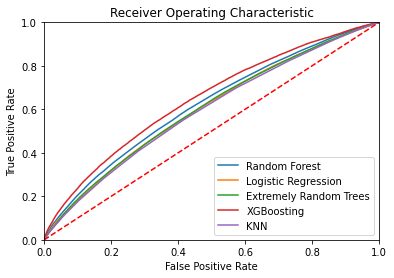

In [92]:
auc_dict = {}

for model_name, model in model_dict.items():
    if model_name == "Naive Bayes":
        continue

    probs = model.predict_proba(X_val)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
    roc_auc = metrics.auc(fpr, tpr)
    auc_dict[model_name] = roc_auc
    plt.plot(fpr, tpr, label = model_name)# + ' AUC = %0.2f' % roc_auc)

#Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("model_comparison.png", dpi=900,bbox_inches="tight")

In [58]:
auc_dict

{'Random Forest': 0.6184791846455395,
 'Logistic Regression': 0.5993552191337106,
 'Extremely Random Trees': 0.6010118568151196,
 'XGBoosting': 0.6460464352864186,
 'KNN': 0.5926010480003984}

Let's now tune the hyperparameters for the best performing algorithm, XGBoost

Ideally, we would do this for all algorithms, but for the sake of time, we'll just do XGBoost

In [148]:
#Compare eta (learning rate) scores
eta_scores = {}
alphas = np.arange(.01,.4,.01)


for a in alphas:
    xgboost = XGBClassifier(eta = a, eval_metric = "logloss")
    xgboost.fit(X_test, y_test)
    y_pred = xgboost.predict(X_val)
    probs = xgboost.predict_proba(X_val)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
    roc_auc = metrics.auc(fpr, tpr)
    f1 = metrics.f1_score(y_val,y_pred)
    eta_scores[a] = (f1, roc_auc)
    
    print("a:{A} f1:{F1} AUC:{auc}".format(A=a,F1=f1,auc=roc_auc))

a:0.01 f1:0.14544979079497905 AUC:0.6362756841144569
a:0.02 f1:0.1402556331532481 AUC:0.6428707907282831
a:0.03 f1:0.14517483986138824 AUC:0.6462821590372829
a:0.04 f1:0.15271154196961406 AUC:0.6479654390327503
a:0.05 f1:0.16122533319557805 AUC:0.649089073016563
a:0.060000000000000005 f1:0.1680207078602732 AUC:0.6498361332433608
a:0.06999999999999999 f1:0.17473255221599593 AUC:0.6506598794076806
a:0.08 f1:0.17604148133085937 AUC:0.6507140480529136
a:0.09 f1:0.1834061135371179 AUC:0.6510470852974588
a:0.09999999999999999 f1:0.18399375267652468 AUC:0.6507531820339417
a:0.11 f1:0.18432368546785025 AUC:0.6507081708308495
a:0.12 f1:0.19050477762769524 AUC:0.651045027542517
a:0.13 f1:0.18716791979949873 AUC:0.6509406477988195
a:0.14 f1:0.1925634448235499 AUC:0.6510965445062228
a:0.15000000000000002 f1:0.19617569008705144 AUC:0.6505263959725666
a:0.16 f1:0.197880558581757 AUC:0.6518739413836253
a:0.17 f1:0.2048121777559538 AUC:0.6502097924152022
a:0.18000000000000002 f1:0.20233022144493434 AU

A learning rate of .16 wins

In [154]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1, .16, .2],
           'n_estimators': [100],
           'colsample_bytree': [0.3, 0.7]}

xgbr = XGBClassifier(seed = 42,eval_metric="logloss")
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='roc_auc', 
                   verbose=2)

clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Highest AUC: ", clf.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   2.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   4.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   4.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   4.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   4.6s
[CV] END colsample_bytree=0.3

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   8.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   8.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   8.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   8.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100; total time=  15.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100; total time=  15.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100; total time=  15.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100; total time=  15.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100; total time=  15.5s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100; tota

In [18]:
#Compute percent accidents

percent_har = crash_df.HAR.sum()/crash_df.shape[0]

#Percent of fatalities that are HAR
percent_fatal_har = crash_df[crash_df.INJURIES_FATAL > 0].HAR.sum()/crash_df[crash_df.INJURIES_FATAL > 0].shape[0]

#Percent of pedestrian accidents that are HAR
percent_ped_har = crash_df[crash_df.FIRST_CRASH_TYPE == "PEDESTRIAN"].HAR.sum()/crash_df[crash_df.FIRST_CRASH_TYPE == "PEDESTRIAN"].shape[0]

print(percent_har, percent_fatal_har, percent_ped_har)

0.290916998184162 0.1824212271973466 0.3475526594938627


In [19]:
#Accidents by hour
#See above

In [21]:
#Neighborhood HAR percentage vs. median income

Let's work on using the geodata and combining it with Neighborhood geodata

In [59]:
neigh_df = geopandas.read_file("neighborhoods.csv")
neigh_df["geometry"] = geopandas.GeoSeries.from_wkt(neigh_df['the_geom'])
neigh_df = neigh_df.set_crs("EPSG:4326")

neigh_df.set_index("PRI_NEIGH", inplace=True)

In [60]:
neigh_df.dtypes

the_geom        object
SEC_NEIGH       object
SHAPE_AREA      object
SHAPE_LEN       object
geometry      geometry
dtype: object

<AxesSubplot:>

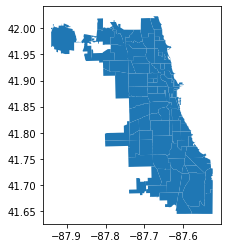

In [61]:
neigh_df.plot()

In [62]:
crash_df["GEOMETRY"] = geopandas.GeoSeries.from_wkt(crash_df["LOCATION"])

In [63]:
def find_neigh(location):
    if location is None:
        return None
    for neigh in neigh_df.index:
        if location.within(neigh_df.loc[neigh,"geometry"]):
            return neigh
    return None
            
crash_df["neigh"] = crash_df.GEOMETRY.apply(find_neigh)

In [64]:
def neigh_percent_har(n):
    mask = crash_df4.neigh == n
    return 100*crash_df4[mask].HAR.sum()/mask.sum()

In [66]:
features = ["POSTED_SPEED_LIMIT",
            "BEAT_OF_OCCURRENCE","CRASH_HOUR","CRASH_DAY_OF_WEEK",
            "CRASH_MONTH","LATITUDE","LONGITUDE", "DARK", "VIS_WEATHER","OVERCAST","NO_TRAFFIC_CONTROL",
           "WORK_ZONE","DRY","neigh"]

crash_df4 = crash_df[features+["HAR"]].dropna()

In [67]:
neigh_percent_har("Lincoln Park")

22.762970014278913

In [68]:
neigh_df.reset_index(inplace=True)

neigh_df["percent_har"] = neigh_df.PRI_NEIGH.apply(neigh_percent_har)

In [69]:
neigh_df

,PRI_NEIGH,the_geom,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,geometry,percent_har
0,Grand Boulevard,MULTIPOLYGON (((-87.60670812560372 41.81681377...,BRONZEVILLE,48492503.1554,28196.837157,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",33.674514
1,Printers Row,MULTIPOLYGON (((-87.62760697485348 41.87437097...,PRINTERS ROW,2162137.97139,6864.247156,"MULTIPOLYGON (((-87.62761 41.87437, -87.62760 ...",18.290258
2,United Center,MULTIPOLYGON (((-87.66706868914602 41.88885187...,UNITED CENTER,32520512.7053,23101.363745,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ...",29.747485
3,Sheffield & DePaul,MULTIPOLYGON (((-87.65833494805533 41.92166144...,SHEFFIELD & DEPAUL,10482592.2987,13227.049745,"MULTIPOLYGON (((-87.65833 41.92166, -87.65835 ...",23.626853
4,Humboldt Park,MULTIPOLYGON (((-87.74059567509266 41.88782316...,HUMBOLDT PARK,125010425.593,46126.751351,"MULTIPOLYGON (((-87.74060 41.88782, -87.74060 ...",35.401460
...,...,...,...,...,...,...,...
93,Belmont Cragin,MULTIPOLYGON (((-87.74142999502229 41.91698483...,"BELMONT CRAGIN,HERMOSA",109099407.211,43311.706886,"MULTIPOLYGON (((-87.74143 41.91698, -87.74141 ...",30.883934
94,Austin,MULTIPOLYGON (((-87.75619515209075 41.91546954...,AUSTIN,170037750.826,55473.345911,"MULTIPOLYGON (((-87.75620 41.91547, -87.75588 ...",39.294596
95,Gold Coast,MULTIPOLYGON (((-87.62645810267597 41.91147052...,GOLD COAST,7165705.53467,13685.479377,"MULTIPOLYGON (((-87.62646 41.91147, -87.62640 ...",19.414550
96,Boystown,MULTIPOLYGON (((-87.64878470805166 41.93998753...,BOYSTOWN,3365778.97115,9780.268985,"MULTIPOLYGON (((-87.64878 41.93999, -87.64927 ...",24.285714


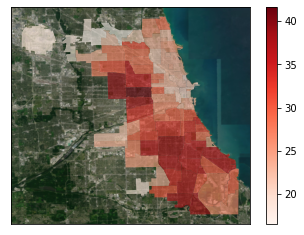

In [71]:
base = neigh_df.plot("percent_har", legend = True, alpha = .6,
                    cmap = plt.get_cmap("Reds"))

plt.xticks([])
plt.yticks([])

#Give key for contextily tileset
ctx.add_basemap(base, attribution=False, 
                source=ctx.providers.MapTiler.Satellite(key="gkcz91MMrEyfto0Flbbc") 
                ,crs=neigh_df.crs.to_string())

plt.savefig("neigh_har_rate.png", dpi=900,bbox_inches="tight")

In [72]:
income_df = pd.read_csv("neighborhood_income.csv")

In [73]:
income_df

,neighborhood,med_income
0,Albany Park,40711.0
1,Archer Heights,39431.0
2,Armour Square,22756.0
3,Ashburn,53633.0
4,Auburn Gresham,34238.0
...,...,...
72,West Lawn,47017.0
73,West Pullman,40478.0
74,West Ridge,41144.0
75,West Town,38915.0


In [74]:
neigh_df2 = income_df.set_index("neighborhood").join(neigh_df.set_index("PRI_NEIGH"))

In [75]:
neigh_df2 = neigh_df2[["med_income","percent_har"]].dropna()

In [76]:
neigh_df2

,med_income,percent_har
neighborhood,,
Albany Park,40711.0,31.136482
Archer Heights,39431.0,25.417989
Armour Square,22756.0,28.438228
Ashburn,53633.0,24.789863
Auburn Gresham,34238.0,36.571782
...,...,...
West Lawn,47017.0,26.772547
West Pullman,40478.0,37.516719
West Ridge,41144.0,25.723234


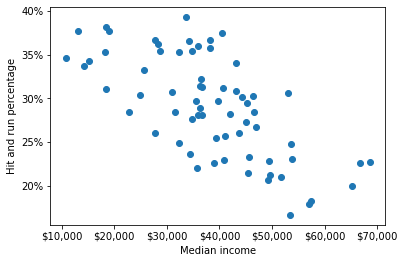

In [88]:
ax = plt.scatter(neigh_df2.med_income, neigh_df2.percent_har)
ylabs = [str(x)+"%" for x in range(20,45,5)]
xlabs = ["$"+str(x)+",000" for x in range(10,80,10)]
plt.yticks(ticks=np.arange(20,45,5),labels=ylabs)
plt.xticks(ticks=np.arange(10000,80000,10000),labels=xlabs)

plt.ylabel("Hit and run percentage")
plt.xlabel("Median income")
plt.savefig("income_vs_har_rate.png", dpi=900,bbox_inches="tight")

In [293]:
crash_df5 = crash_df4.set_index("neigh").join(neigh_df2)

In [294]:
crash_df5["med_income"] = crash_df5.med_income.fillna(38625.00)

In [299]:
crash_df5.reset_index(inplace=True)

In [303]:
features = ["POSTED_SPEED_LIMIT",
            "BEAT_OF_OCCURRENCE","CRASH_HOUR","CRASH_DAY_OF_WEEK",
            "CRASH_MONTH","LATITUDE","LONGITUDE", "DARK", "VIS_WEATHER","OVERCAST","NO_TRAFFIC_CONTROL",
           "WORK_ZONE","DRY","med_income"]

crash_df5 = crash_df5[features + ["HAR"]]

In [306]:
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(crash_df5, target = 'HAR', 
                                                                train_size=0.6, valid_size=0.2, test_size=0.2)

In [308]:
xgboost = XGBClassifier()
xgboost.fit(X_test, y_test)

y_pred = xgboost.predict(X_val)
metrics.f1_score(y_val,y_pred)

[16:50:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.22432000762831056

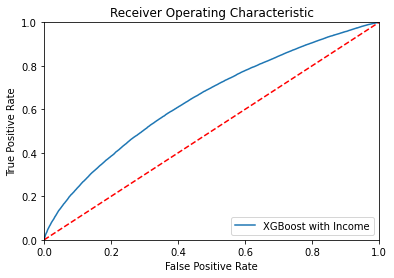

In [309]:
probs = xgboost.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)
auc_dict[model_name] = roc_auc
plt.plot(fpr, tpr, label = "XGBoost with Income")# + ' AUC = %0.2f' % roc_auc)

#Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()